In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as random
from calibration_util import *
%matplotlib inline
%precision %.4f

C:\Users\Caitlin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'%.4f'

In [2]:
data = generate(10000,5,0.2,99)

In [3]:
under_data = under_rank(data, .25, 0., 0.)
over_data = under_rank(under_data, .25, 1., 1.)
df_under = data[['y','g']]
df_under['y_pred'] =under_data['y']
df_over = data[['y','g']]
df_over['y_pred'] =over_data['y']

C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
# (df, folds, nbins, r)

# vary number of bins

for f in 3,5,10,20 :
    print(f, " folds:")
    print(train_test_short(df_under, 10, f, 99))

3  folds:
                     baseline  calibrate  cal_groups
Mean Squared Error   0.026708   0.005195    0.006185
Absolute Error      86.660561  32.395610   54.625153
Overestimation       0.000000   3.759447   27.283061
Underestimation     86.660561  33.793389   27.342092
Spearman Rho         0.534179   0.387575    0.539889
Kendall Tau          0.428714   0.349372    0.480861
KL divergence        0.069720   0.010640    0.014033
5  folds:
                     baseline  calibrate  cal_groups
Mean Squared Error   0.026928   0.005208    0.006133
Absolute Error      52.217004  19.172816   32.573971
Overestimation       0.000000   1.084149   16.435178
Underestimation     52.217004  20.066876   16.138794
Spearman Rho         0.562327   0.567808    0.626229
Kendall Tau          0.366591   0.451244    0.509171
KL divergence        0.057735   0.012444    0.014442
10  folds:


C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:70: RuntimeWarning: invalid value encountered in double_scalars
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))


                     baseline  calibrate  cal_groups
Mean Squared Error   0.027535   0.005888    0.006100
Absolute Error      26.453947  10.222370   15.985549
Overestimation       0.000000   1.131861    7.374299
Underestimation     26.453947  10.621604    8.611250
Spearman Rho         0.678756   0.546051    0.753137
Kendall Tau          0.350330   0.151984    0.319925
KL divergence        0.036927   0.012133    0.013661
20  folds:
                     baseline  calibrate  cal_groups
Mean Squared Error   0.027326   0.005638    0.006506
Absolute Error      13.109146   4.995879    8.094528
Overestimation       0.000000   0.862931    3.940166
Underestimation     13.109146   5.163053    4.154362
Spearman Rho         0.760804   0.650529    0.781685
Kendall Tau          0.333439   0.209021    0.292801
KL divergence        0.025838   0.008586    0.009894


In [19]:
def get_overall_errors(y_hat, y, g):
    results = pd.DataFrame()
    results['y_pred'] = y_hat
    results['y'] = y
    results['g'] = g
    results = results.sort_values('y_pred')
    results0 = np.array(results[results['g']==0.][["y_pred","y"]])
    results1 = np.array(results[results['g']==1.][["y_pred","y"]])
    
    errors = pd.DataFrame()
    errors['mse0'] = get_mse(results0)
    errors['mse1'] = get_mse(results1)
    errors['bin_mse_diff']=(errors['mse0']-errors['mse1']).abs()
    errors['ae0'] = get_ae(results0)
    errors['ae1'] = get_ae(results1)
    
    errors['bin_ae_diff']=(errors['ae0']-errors['ae1']).abs()
    errors['oe0'] = get_oe(results0)
    errors['oe1'] = get_oe(results1)
    errors['bin_oe_diff']=(errors['oe0']-errors['oe1']).abs()
    errors['ue0'] = get_ue(results0)
    errors['ue1'] = get_ue(results1)
    errors['bin_ue_diff']=(errors['ue0']-errors['ue1']).abs()
    
    #need to convert scores to ranks to compute ranking correlation
    ranks= results.copy()
    ranks["y_pred"]=results["y_pred"].rank(method="average")
    ranks["y"]=results["y"].rank(method="average")
    ranks0 = np.array(results[ranks['g']==0.][["y_pred","y"]])
    ranks1 = np.array(results[ranks['g']==1.][["y_pred","y"]])
    
    errors['spear0'] = get_spear(results0)
    errors['spear1'] = get_spear(results1)
    errors['bin_spear_diff']=(errors['spear0']-errors['spear1']).abs()
    
    
    errors['kendall0'] = get_kendall(results0)
    errors['kendall1'] = get_kendall(results1)
    errors['bin_kendall_diff']=(errors['kendall0']-errors['kendall1']).abs()
    
    
    errors['kl0'] = get_kl(results0)
    errors['kl1'] = get_kl(results1)
    errors['bin_kl_diff']=(errors['kl0']-errors['kl1']).abs()
    return errors[['bin_mse_diff','bin_ae_diff', 'bin_oe_diff', 'bin_ue_diff', 
                   'bin_spear_diff','bin_kendall_diff', 'bin_kl_diff']]

In [22]:
def train_test_overall(df):
    cv_errors =pd.DataFrame()
    train = df.sample(frac=0.25)
    test = df.drop(train.index)

    y_pred_baseline = test['y_pred']

    y_pred_cal = get_calibrated_predictions(train, test)
    
    y_pred0, y_pred1 = get_groupwise_calibrated_predictions(train, test)
    y_pred_all = np.append(y_pred0, y_pred1)

    y_test0 = test[test['g']==0.]['y']
    y_test1 = test[test['g']==1.]['y']
    y_test_all = np.append(y_test0, y_test1)

    g_test0 = test[test['g']==0.]['g']
    g_test1 = test[test['g']==1.]['g']
    g_test_all = np.append(g_test0, g_test1)

    y_test = np.array(test['y'])
    g_test = np.array(test['g'])

    b_errors = get_overall_errors(y_pred_baseline, y_test, g_test)
    print(b_errors)
    cv_errors["baseline"] = b_errors
    c_errors = get_overall_errors(y_pred_cal, y_test, g_test)
    cv_errors["calibrate"] = c_errors
    cg_errors = get_overall_errors(y_pred_all, y_test_all, g_test_all)
    cv_errors["cal_groups"] = cg_errors
    cv_errors.index = ['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation', 'Spearman Rho', 'Kendall Tau', 'KL divergence']

In [23]:
train_test_overall(df_under)

Empty DataFrame
Columns: [bin_mse_diff, bin_ae_diff, bin_oe_diff, bin_ue_diff, bin_spear_diff, bin_kendall_diff, bin_kl_diff]
Index: []


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [183]:
cv_errors_u = cross_validate(df_under, 10, 10, 99)
cv_errors_u[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']] = cv_errors_u[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs()
cv_errors_u.groupby("method").mean()

0
1
2
3
4
5
6
7
8
9


,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,bin_oe_diff,ue0,ue1,bin_ue_diff,spear0,spear1,bin_spear_diff
method,,,,,,,,,,,,,,
baseline,0.019589,0.000000e+00,0.019589,3.465787,0.000000,3.465787,3.465787,3.465787,0.000000,0.000000,0.000000,0.861590,1.020425,0.159356
cal_groups,0.005922,8.716489e-09,0.005922,2.082197,0.000092,2.082222,1.040081,1.040139,-1.042116,-0.000034,1.042083,0.550446,1.020425,0.470409
calibrate,0.006508,1.707489e-03,0.005741,2.046186,0.786167,1.595645,1.416239,1.416298,-0.629948,-0.786108,0.828919,0.655455,0.836806,0.325416


In [45]:
cv_errors_u

,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,oe1,bin_oe_diff,ue0,ue1,bin_ue_diff,spear0,spear1,bin_spear_diff,method,iteration
0,0.040992,0.000000,0.040992,9.712276,0.000000,9.712276,9.712276,0,9.712276,0.000000,0.000000,0.000000,0.719005,1.000000,2.809955e-01,baseline,0
1,0.068633,0.000000,0.068633,12.679749,0.000000,12.679749,12.679749,0,12.679749,0.000000,0.000000,0.000000,0.915023,1.000000,8.497738e-02,baseline,0
2,0.062376,0.000000,0.062376,9.913664,0.000000,9.913664,9.913664,0,9.913664,0.000000,0.000000,0.000000,0.264796,1.000000,7.352036e-01,baseline,0
3,0.019811,0.000000,0.019811,2.657594,0.000000,2.657594,2.657594,0,2.657594,0.000000,0.000000,0.000000,0.486063,1.000000,5.139367e-01,baseline,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,baseline,0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,baseline,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,baseline,0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,baseline,0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,baseline,0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,baseline,0


In [44]:
cv_errors_o = cross_validate(df_over, 10, 10, 99)
cv_errors_o[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']] = cv_errors_o[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs()
cv_errors_o.groupby("method").mean()

C:\Users\Caitlin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Caitlin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Caitlin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Caitlin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Caitlin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0
1
2
3
4
5
6
7
8
9


,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,oe1,bin_oe_diff,ue0,ue1,bin_ue_diff,spear0,spear1,bin_spear_diff
method,,,,,,,,,,,,,,,
baseline,0.019589,0.019280,0.037761,3.465787,3.385021,0.080767,3.465787,0.000000,3.465787,0.000000,-3.385021,3.385021,0.844326,0.758185,0.323130
calibrate,0.007258,0.006526,0.008537,2.632604,2.604214,0.028390,1.961986,0.655832,1.817211,-0.670617,-1.948382,1.803642,0.815755,0.631158,0.457516
calibrate_groups,0.005922,0.004735,0.008798,2.082197,2.114731,-0.032534,1.040081,1.057308,1.563198,-1.042116,-1.057423,1.608590,0.768193,0.688272,0.541993


In [22]:
# cv_errors.groupby("method").mean().columns.values

In [23]:
# Study impact of penalizing a single group

results = pd.DataFrame(columns=['mse0', 'mse1', 'bin_mse_diff', 'ae0', 'ae1', 'bin_ae_diff', 'oe0',
       'oe1', 'bin_oe_diff', 'ue0', 'ue1', 'bin_ue_diff', 'spear0', 'spear1', 'bin_spear_diff','amount','penalty'])
#vary amount of group affected
for a in 0.1, 0.25, 0.5, 0.75, 0.9:
    #vary penalty amount
    for p in 0.1, 0.25, 0.5, 0.75, 0.9:
        under_data = under_rank(data, a, p, 0.)
        df = data[['y','g']]
        df['y_pred'] =under_data['y']
        cv_errors = cross_validate(df, 10, 10, 99)
        cv_errors[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']] = cv_errors[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs()
        cv_errors['amount']=a
        cv_errors['penalty']=p
        
        results = pd.concat([results, cv_errors.groupby("method").mean()])
    

C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [24]:
# Study impact of penalizing one group and rewarding another

results = pd.DataFrame(columns=['mse0', 'mse1', 'bin_mse_diff', 'ae0', 'ae1', 'bin_ae_diff', 'oe0',
       'oe1', 'bin_oe_diff', 'ue0', 'ue1', 'bin_ue_diff', 'spear0', 'spear1', 'bin_spear_diff','amount','penalty'])
#vary amount of group affected
for a in 0.1, 0.25, 0.5, 0.75, 0.9:
    #vary penalty amount
    for p in 0.1, 0.25, 0.5, 0.75, 0.9:
        under_data = under_rank(data, a, p, 0.)
        under_data = under_rank(data, a, (1+p), 1.)
        df = data[['y','g']]
        df['y_pred'] =under_data['y']
        cv_errors = cross_validate(df, 10, 10, 99)
        cv_errors[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']] = cv_errors[['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs()
        cv_errors['amount']=a
        cv_errors['penalty']=p
        
        results2 = pd.concat([results, cv_errors.groupby("method").mean()])
    

C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [25]:
results


,ae0,ae1,amount,bin_ae_diff,bin_mse_diff,bin_oe_diff,bin_spear_diff,bin_ue_diff,mse0,mse1,oe0,oe1,penalty,spear0,spear1,ue0,ue1
baseline,2.472797,0.000000,0.1,2.472797,0.025396,0.000000,0.182671,2.472797,0.025396,0.000000,0.000000,0.000000,0.10,0.817329,1.000000,-2.472797,NaN
calibrate,1.090564,0.397636,0.1,0.692928,0.003315,0.198248,0.156497,0.743128,0.004119,0.000840,0.347436,0.397636,0.10,0.842275,0.998772,-0.743128,NaN
calibrate_groups,1.191843,0.001147,0.1,1.190697,0.003828,0.596129,0.143846,0.594567,0.003829,0.000001,0.596252,0.000122,0.10,0.856154,1.000000,-0.595592,NaN
baseline,1.957926,0.000000,0.1,1.957926,0.016506,0.000000,0.165291,1.957926,0.016506,0.000000,0.000000,0.000000,0.25,0.834709,1.000000,-1.957926,NaN
calibrate,1.018728,0.373606,0.1,0.645123,0.003024,0.192871,0.140785,0.695238,0.003740,0.000781,0.323490,0.373606,0.25,0.858111,0.998896,-0.695238,NaN
calibrate_groups,1.114894,0.001147,0.1,1.113747,0.003473,0.557760,0.130595,0.555987,0.003474,0.000001,0.557883,0.000122,0.25,0.869405,1.000000,-0.557011,NaN
baseline,1.299963,0.000000,0.1,1.299963,0.007425,0.000000,0.159505,1.299963,0.007425,0.000000,0.000000,0.000000,0.50,0.840495,1.000000,-1.299963,NaN
calibrate,1.096416,0.408692,0.1,0.687724,0.003193,0.169460,0.153338,0.752408,0.003899,0.000716,0.344008,0.408692,0.50,0.846008,0.999347,-0.752408,NaN
calibrate_groups,1.187592,0.001147,0.1,1.186445,0.003593,0.593663,0.141378,0.592782,0.003594,0.000001,0.593785,0.000122,0.50,0.858622,1.000000,-0.593806,NaN


In [ ]:
results2

In [32]:
results.reset_index(inplace=True)

In [107]:
def heatmap(results, method, error, min, max):
    rs = results[results['index']==method][[error, 'amount', 'penalty']]
#     scale(rs, error)
    rs = rs.pivot_table(index='amount', columns='penalty', values=error)
    sns.heatmap(rs, annot=True, fmt="g", cmap='viridis', vmin=min, vmax=max)
    plt.title(method+" "+error)
    plt.show()

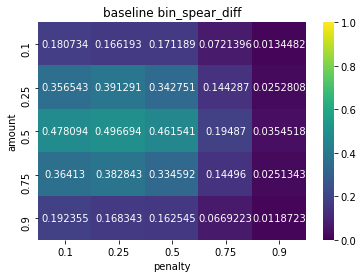

In [90]:
heatmap(results, 'baseline', 'bin_spear_diff')

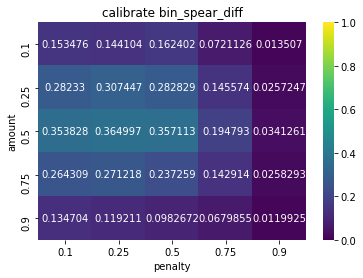

In [91]:
heatmap(results, 'calibrate', 'bin_spear_diff')

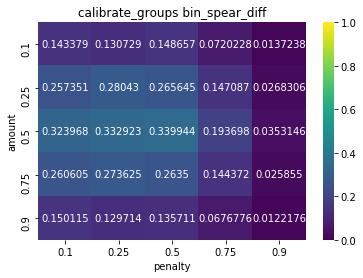

In [92]:
heatmap(results, 'calibrate_groups', 'bin_spear_diff')

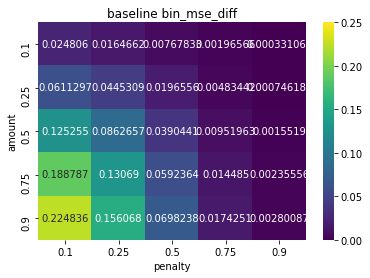

In [104]:
heatmap(results, 'baseline', 'bin_mse_diff')

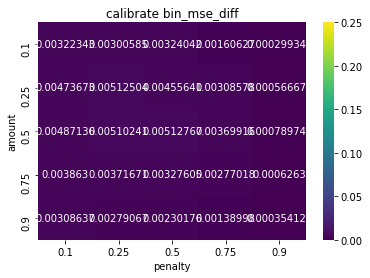

In [105]:
heatmap(results, 'calibrate', 'bin_mse_diff')

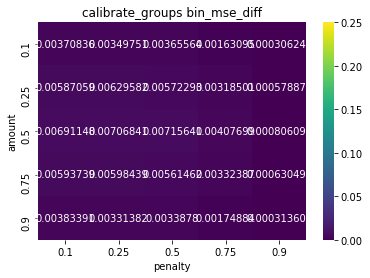

In [106]:
heatmap(results, 'calibrate_groups', 'bin_mse_diff')

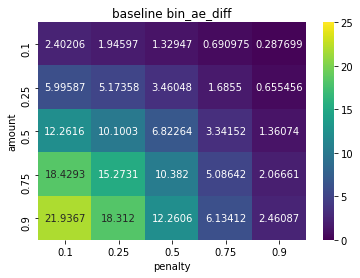

In [108]:
heatmap(results, 'baseline', 'bin_ae_diff')

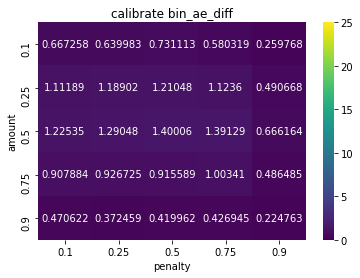

In [109]:
heatmap(results, 'calibrate', 'bin_ae_diff')

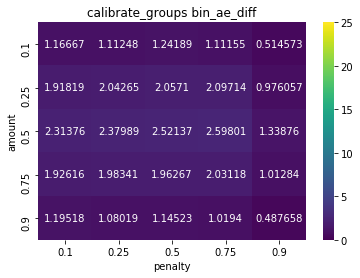

In [110]:
heatmap(results, 'calibrate_groups', 'bin_ae_diff')